# Runway Baseline Analysis Notebook

**Created:** 2025-11-10 17:53 UTC

This notebook performs baseline analysis on runway chips: histogram plotting, feature extraction (moments, entropy, percentiles), synthetic damage generation, and a simple Random Forest classifier. It's designed to run locally in your repository (where your `chips/` and `data/` folders live).

**How to use:**
1. Open this notebook in Jupyter (or VS Code's Jupyter). 
2. Ensure your Python environment has the required packages (see the first cell).
3. Adjust `ROOT_DIR` paths in the *Configuration* cell if your repo layout differs.

---


In [47]:
# Install required packages (run if needed)
# It's recommended to run these in your active venv (e.g. .venv).
# Uncomment and run if you haven't installed these packages already.

# !pip install pillow numpy scipy matplotlib scikit-learn opencv-python pandas tqdm


In [48]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [49]:
# 1 - CONFIGURATION & HELPERS
from pathlib import Path
import numpy as np
from PIL import Image
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import math, os


ROOT = Path(".").resolve()
CHIP = ROOT / "chips" / "misawa_airbase.Misawa_Airbase.Runway_1.tif"
OUT_DIR = ROOT / "analysis_out"
OUT_DIR.mkdir(exist_ok=True, parents=True)

# image intensity considered "background" threshold: sum of RGB <= BG_THRESH is background
BG_THRESH = 5   # tune if image uses near-black background/padding

print("Image:", CHIP)
print("Out dir:", OUT_DIR)


Image: C:\Users\bengb\OneDrive\Documents\SATSAR_Extract\chips\misawa_airbase.Misawa_Airbase.Runway_1.tif
Out dir: C:\Users\bengb\OneDrive\Documents\SATSAR_Extract\analysis_out


In [50]:
# 2 - LOAD + GLOBAL MOMENTS
img = Image.open(CHIP).convert("RGB")
arr = np.array(img)        # H x W x 3, uint8
h, w = arr.shape[:2]
print("shape:", arr.shape)

def channel_moments(flat):
    # flat: 1D array of intensities (0..255)
    flat = flat.astype(np.float64)
    m = flat.mean()
    var = flat.var(ddof=0)
    sd = math.sqrt(var)
    sk = float(skew(flat)) if flat.size>0 else 0.0
    k = float(kurtosis(flat, fisher=True)) if flat.size>0 else 0.0
    return {"mean": m, "std": sd, "var": var, "skew": sk, "kurtosis": k}

# compute for each channel and grayscale
channels = {'R': arr[:,:,0].ravel(), 'G': arr[:,:,1].ravel(), 'B': arr[:,:,2].ravel()}
gray = (0.2989 * arr[:,:,0] + 0.5870 * arr[:,:,1] + 0.1140 * arr[:,:,2]).ravel()
channels['L'] = gray

global_stats = {}
for name, flat in channels.items():
    global_stats[name] = channel_moments(flat)

pd.DataFrame(global_stats).T.round(4)
# optionally save
pd.DataFrame(global_stats).T.to_csv(OUT_DIR / "global_moments.csv")
print("Wrote global_moments.csv")


shape: (591, 5150, 3)
Wrote global_moments.csv


In [51]:
# 3 - MASK BACKGROUND (runway-only) & MOMENTS
mask = (arr.sum(axis=2) > BG_THRESH)   # boolean mask where any channel > threshold
runway_pixels = arr[mask]              # N x 3 array

if runway_pixels.size == 0:
    raise SystemExit("No runway pixels found with BG_THRESH. Increase threshold.")

# per-channel runway moments
runway_stats = {}
for i, name in enumerate(['R','G','B']):
    runway_stats[name] = channel_moments(runway_pixels[:, i])
# grayscale
runway_stats['L'] = channel_moments((0.2989*runway_pixels[:,0] + 0.5870*runway_pixels[:,1] + 0.1140*runway_pixels[:,2]))

pd.DataFrame(runway_stats).T.to_csv(OUT_DIR / "runway_moments.csv")
print("Wrote runway_moments.csv")
pd.DataFrame(runway_stats).T.round(4)


Wrote runway_moments.csv


,mean,std,var,skew,kurtosis
R,129.8212,42.7155,1824.6147,0.9624,0.4155
G,125.0574,42.2609,1785.9847,1.0054,0.4789
B,125.6881,38.5646,1487.2293,1.1774,1.0111
L,126.5407,41.8308,1749.8145,1.0212,0.5139


In [52]:
# 4 - EXTRA DIAGNOSTICS: percentiles, entropy, mode-ish
from scipy.stats import entropy
import numpy as np

def extra_stats(flat):
    flat = flat.astype(np.int64)
    pcts = np.percentile(flat, [1,5,25,50,75,95,99]).tolist()
    # histogram-based Shannon entropy
    counts = np.bincount(flat, minlength=256).astype(np.float64)
    probs = counts / counts.sum()
    probs = probs[probs > 0]
    ent = float(-(probs * np.log2(probs)).sum()) if probs.size > 0 else 0.0
    # approximate mode: the intensity with max count
    mode = int(np.argmax(counts))
    return {"p1": pcts[0], "p5": pcts[1], "p25": pcts[2], "median": pcts[3],
            "p75": pcts[4], "p95": pcts[5], "p99": pcts[6],
            "entropy": ent, "mode": mode}

runway_extra = {}
for i, name in enumerate(['R','G','B']):
    runway_extra[name] = extra_stats(runway_pixels[:, i])
runway_extra['L'] = extra_stats((0.2989*runway_pixels[:,0] + 0.5870*runway_pixels[:,1] + 0.1140*runway_pixels[:,2]).astype(np.int64))

pd.DataFrame(runway_extra).T.to_csv(OUT_DIR / "runway_extra_stats.csv")
print("Wrote runway_extra_stats.csv")
pd.DataFrame(runway_extra).T.round(4)


Wrote runway_extra_stats.csv


,p1,p5,p25,median,p75,p95,p99,entropy,mode
R,48.0,78.0,103.0,120.0,138.0,213.0,250.0,7.0057,131.0
G,52.0,75.0,96.0,116.0,134.0,206.0,248.0,7.0281,127.0
B,65.0,81.0,99.0,118.0,133.0,201.0,247.0,6.8854,126.0
L,52.0,76.0,98.0,117.0,134.0,206.0,248.0,6.9982,128.0


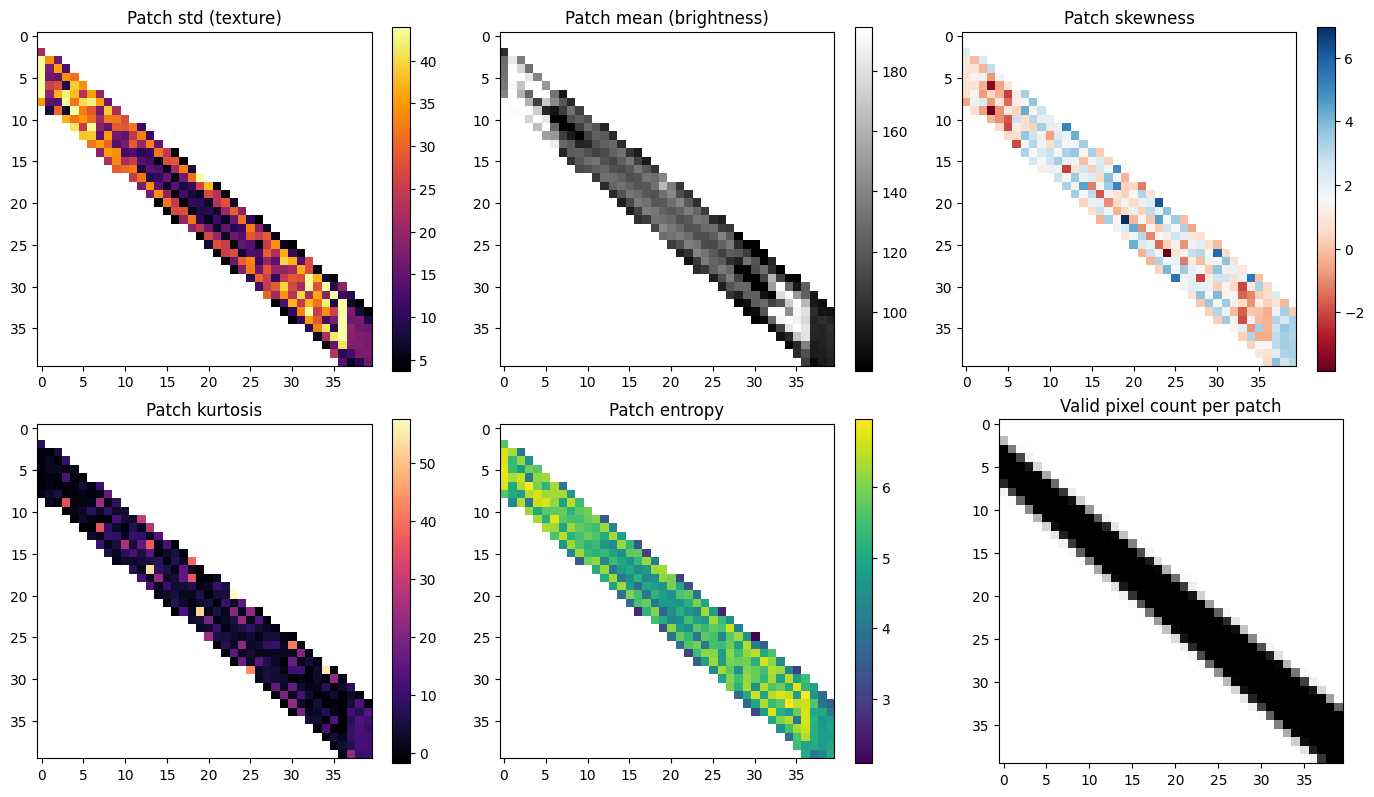

Wrote patch_moments_heatmaps.png


In [53]:
# 5 - PATCH / SLIDING-WINDOW MOMENTS (grid-based)
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

grid_size = 40   # e.g., 40x40 patches. Increase -> smaller patches.
ph = h // grid_size
pw = w // grid_size

# prepare maps
mean_map = np.full((grid_size, grid_size), np.nan)
std_map  = np.full((grid_size, grid_size), np.nan)
skew_map = np.full((grid_size, grid_size), np.nan)
kurt_map = np.full((grid_size, grid_size), np.nan)
ent_map  = np.full((grid_size, grid_size), np.nan)
count_map = np.zeros((grid_size, grid_size), dtype=int)

for iy in range(grid_size):
    for ix in range(grid_size):
        y0, y1 = iy*ph, min((iy+1)*ph, h)
        x0, x1 = ix*pw, min((ix+1)*pw, w)
        patch = arr[y0:y1, x0:x1]
        # mask background inside patch
        patch_mask = (patch.sum(axis=2) > BG_THRESH)
        if patch_mask.sum() < 20:   # skip patches with too few valid pixels
            continue
        valid = patch[patch_mask]
        # work with grayscale for many maps (you can compute per-channel similarly)
        flat = (0.2989*valid[:,0] + 0.5870*valid[:,1] + 0.1140*valid[:,2]).ravel()
        mean_map[iy, ix] = float(flat.mean())
        std_map[iy, ix]  = float(flat.std(ddof=0))
        skew_map[iy, ix] = float(skew(flat))
        kurt_map[iy, ix] = float(kurtosis(flat, fisher=True))
        # entropy
        counts = np.bincount(flat.astype(np.int64), minlength=256).astype(np.float64)
        probs = counts / counts.sum()
        probs = probs[probs>0]
        ent_map[iy, ix] = float(-(probs * np.log2(probs)).sum()) if probs.size>0 else np.nan
        count_map[iy, ix] = int(patch_mask.sum())

# Plot heatmaps for std, skew, kurtosis, mean, entropy
vmin_std, vmax_std = np.nanpercentile(std_map, [5,95])
vmin_mean, vmax_mean = np.nanpercentile(mean_map, [5,95])

fig, axes = plt.subplots(2,3, figsize=(14,8))
axes = axes.ravel()
im0 = axes[0].imshow(std_map, cmap="inferno", vmin=vmin_std, vmax=vmax_std)
axes[0].set_title("Patch std (texture)")
fig.colorbar(im0, ax=axes[0])
im1 = axes[1].imshow(mean_map, cmap="gray", vmin=vmin_mean, vmax=vmax_mean)
axes[1].set_title("Patch mean (brightness)")
fig.colorbar(im1, ax=axes[1])
im2 = axes[2].imshow(skew_map, cmap="RdBu")
axes[2].set_title("Patch skewness")
fig.colorbar(im2, ax=axes[2])
im3 = axes[3].imshow(kurt_map, cmap="magma")
axes[3].set_title("Patch kurtosis")
fig.colorbar(im3, ax=axes[3])
im4 = axes[4].imshow(ent_map, cmap="viridis")
axes[4].set_title("Patch entropy")
fig.colorbar(im4, ax=axes[4])
axes[5].imshow(count_map, cmap="Greys")
axes[5].set_title("Valid pixel count per patch")
plt.tight_layout()
plt.savefig(OUT_DIR / "patch_moments_heatmaps.png", dpi=150)
plt.show()
print("Wrote patch_moments_heatmaps.png")


In [54]:
%pip install skimage

  Using cached skimage-0.0.tar.gz (757 bytes)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [3 lines of output]
      
      *** Please install the `scikit-image` package (instead of `skimage`) ***
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [55]:
from PIL import Image
import numpy as np
from pathlib import Path

# Point to your runway chip
image_path = Path("chips/misawa_airbase.Misawa_Airbase.Runway_1.tif")

# Load image
img = Image.open(image_path).convert("RGB")
img_runway = np.array(img)  # now the variable exists

print("Loaded image shape:", img_runway.shape)


Loaded image shape: (591, 5150, 3)


              mean        std          var      skew  kurtosis   entropy
channel                                                                 
R        20.921360  50.718623  2572.378732  2.365313  4.684030  1.224147
G        20.153654  49.010356  2402.015031  2.395335  4.899814  1.226647
B        20.255290  48.736504  2375.246778  2.320242  4.454969  1.210711
L        20.392692  49.463476  2446.635502  2.375443  4.770882  1.223330


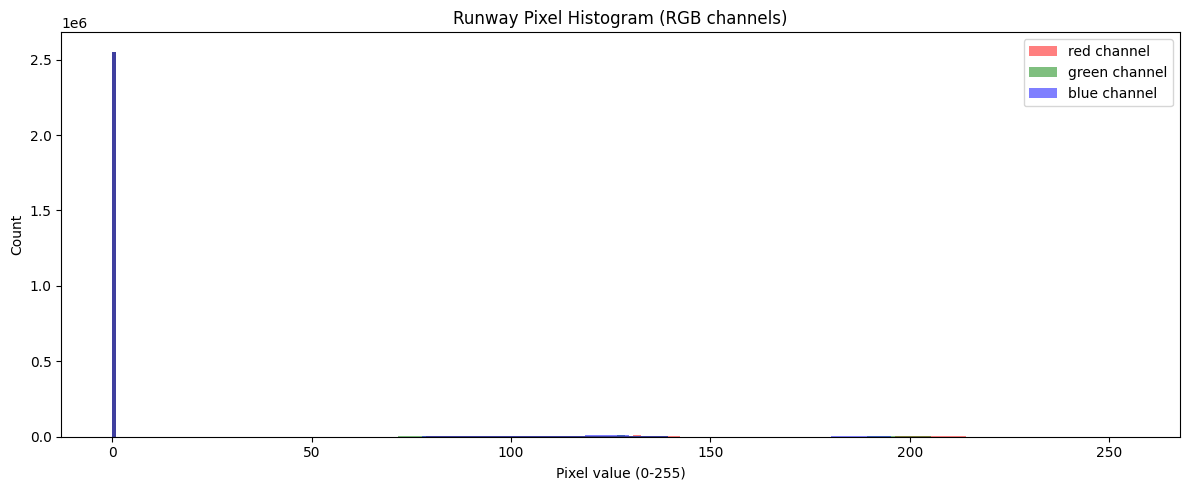

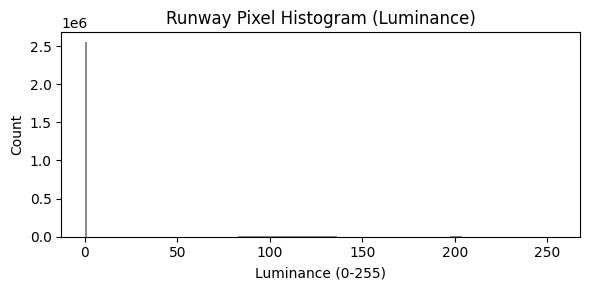

In [56]:
# Moments & histograms for runway pixels (no scikit-image required)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, entropy as shannon_entropy
import pandas as pd

# --- INPUT: img_runway is an HxWx3 uint8/numeric array containing ONLY runway pixels (masked)
# If you currently have a 2D list of pixels (N x 3), you can set:
# pixels = np.array(img_runway).reshape(-1, 3)
# Here we accept either form:
arr = np.array(img_runway)
if arr.ndim == 3:
    pixels = arr.reshape(-1, 3)
elif arr.ndim == 2 and arr.shape[1] == 3:
    pixels = arr.copy()
else:
    raise ValueError("img_runway must be HxWx3 or Nx3 array of RGB pixels")

# Convert to float for stats
pixels = pixels.astype(np.float64)

# Compute grayscale (luminance) WITHOUT skimage: standard Rec. 601 weights
gray = (0.2989 * pixels[:, 0] + 0.5870 * pixels[:, 1] + 0.1140 * pixels[:, 2])

# Prepare channels
channels = ['R', 'G', 'B', 'L']
data = [pixels[:, 0], pixels[:, 1], pixels[:, 2], gray]

# Compute moments & entropy
moment_rows = []
for ch, arr_ch in zip(channels, data):
    arr_ch = arr_ch.ravel().astype(float)
    # numeric stability: ensure non-empty
    if arr_ch.size == 0:
        moment_rows.append({
            "channel": ch, "mean": np.nan, "std": np.nan, "var": np.nan,
            "skew": np.nan, "kurtosis": np.nan, "entropy": np.nan
        })
        continue

    # histogram counts for entropy
    counts, _ = np.histogram(arr_ch, bins=256, range=(0, 255))
    # small smoothing to avoid zero-prob issues
    probs = counts.astype(np.float64)
    if probs.sum() == 0:
        ent = 0.0
    else:
        ent = float(shannon_entropy(probs + 1e-12))  # natural-log entropy; use log base 2 if desired

    moment_rows.append({
        "channel": ch,
        "mean": float(np.mean(arr_ch)),
        "std": float(np.std(arr_ch, ddof=0)),
        "var": float(np.var(arr_ch, ddof=0)),
        "skew": float(skew(arr_ch)),
        "kurtosis": float(kurtosis(arr_ch, fisher=True)),
        "entropy": ent
    })

moment_df = pd.DataFrame(moment_rows).set_index("channel")
print(moment_df.round(6))

# --- Plot nice histograms so you can show them in the meeting ---
plt.figure(figsize=(12,5))
colors = ['red', 'green', 'blue']
for i, c in enumerate(colors):
    plt.hist(data[i], bins=256, range=(0,255), alpha=0.5, label=f"{c} channel", color=c)
plt.title("Runway Pixel Histogram (RGB channels)")
plt.xlabel("Pixel value (0-255)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# Grayscale histogram
plt.figure(figsize=(6,3))
plt.hist(gray, bins=256, range=(0,255), alpha=0.9, color='gray')
plt.title("Runway Pixel Histogram (Luminance)")
plt.xlabel("Luminance (0-255)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [57]:
# Mask out background (black) pixels
mask = np.any(img_runway > 10, axis=-1)  # threshold to ignore black padding
masked_pixels = img_runway[mask]

print("Original pixels:", img_runway.size // 3)
print("Runway-only pixels:", masked_pixels.shape[0])


Original pixels: 3043650
Runway-only pixels: 490500


# New Run

In [58]:
%pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.


In [59]:
from PIL import Image
import numpy as np
import cv2
from pathlib import Path

img_path = Path("chips/misawa_airbase.Misawa_Airbase.Runway_1.tif")
img = cv2.imread(str(img_path))              # BGR order
if img is None:
    raise FileNotFoundError(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB for plotting with matplotlib

# Optional: remove near-black pixels (if any)
bg_thresh = 10   # pixels with all channels <= this are treated as background
mask = np.any(img_rgb > bg_thresh, axis=2)     # True for useful pixels
n_total = img_rgb.shape[0] * img_rgb.shape[1]
n_useful = mask.sum()
print("Total pixels:", n_total, "Useful pixels:", n_useful)
# If mask covers nearly all pixels you can ignore mask and analyze whole image


Total pixels: 3043650 Useful pixels: 490500


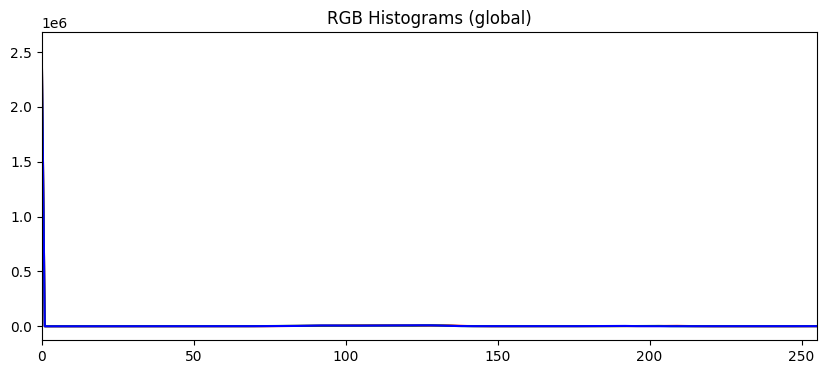

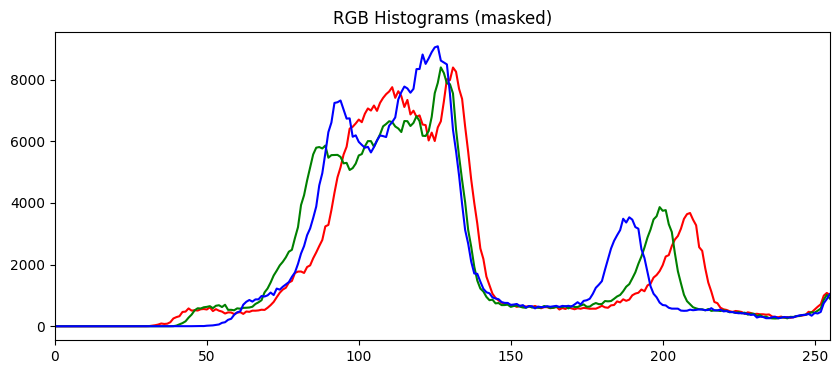

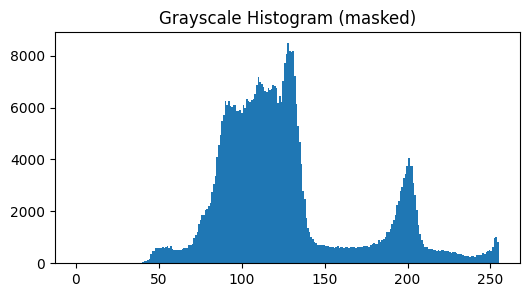

In [60]:
import matplotlib.pyplot as plt

# Grayscale (luminance)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 0..255

# Global histograms
plt.figure(figsize=(10,4))
for i, col in enumerate(("red","green","blue")):
    channel = img_rgb[:,:,i].ravel()
    plt.plot(cv2.calcHist([channel.astype('uint8')], [0], None, [256], [0,256]), color=col)
plt.title("RGB Histograms (global)")
plt.xlim(0,255); plt.show()

# Masked histogram (only useful pixels)
plt.figure(figsize=(10,4))
for i, col in enumerate(("red","green","blue")):
    ch = img_rgb[:,:,i]
    hist = cv2.calcHist([ch.astype('uint8')], [0], mask.astype('uint8'), [256], [0,256])
    plt.plot(hist, color=col)
plt.title("RGB Histograms (masked)")
plt.xlim(0,255); plt.show()

# Grayscale histogram
plt.figure(figsize=(6,3))
plt.hist(gray[mask].ravel(), bins=256, range=(0,255))
plt.title("Grayscale Histogram (masked)")
plt.show()


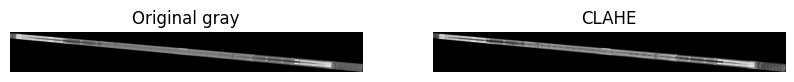

In [61]:
# CLAHE on grayscale for visualization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray_clahe = clahe.apply(gray)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(gray, cmap='gray'); plt.title("Original gray"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(gray_clahe, cmap='gray'); plt.title("CLAHE"); plt.axis('off')
plt.show()


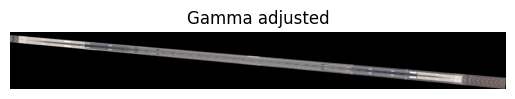

In [62]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i/255.0) ** invGamma) * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

# Example: brighten slightly (gamma < 1 darkens; >1 brightens depending on convention)
img_gamma = adjust_gamma(img, gamma=1.1)
plt.imshow(cv2.cvtColor(img_gamma, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title("Gamma adjusted"); plt.show()


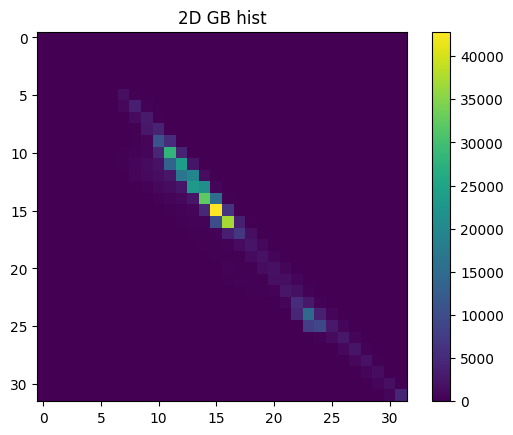

3D hist length: 512


In [63]:
# 2D hist (G vs B)
chans = cv2.split(img)
hist_2d = cv2.calcHist([chans[1], chans[0]], [0,1], mask.astype('uint8'), [32,32], [0,256,0,256])
plt.imshow(hist_2d, interpolation='nearest'); plt.title("2D GB hist"); plt.colorbar(); plt.show()

# 3D hist (8x8x8), flatten to feature vector
hist_3d = cv2.calcHist([img], [0,1,2], mask.astype('uint8'), [8,8,8], [0,256,0,256,0,256])
hist_3d_flat = hist_3d.flatten()
hist_3d_flat = hist_3d_flat / (hist_3d_flat.sum() + 1e-12)  # normalize
print("3D hist length:", hist_3d_flat.size)


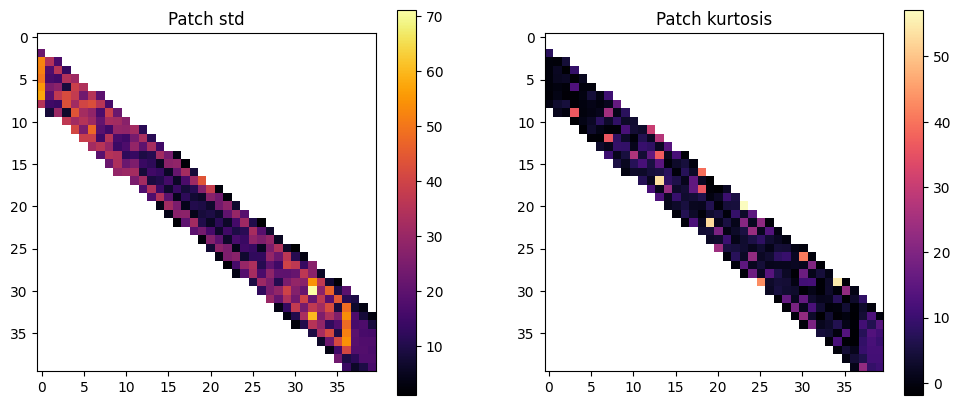

In [64]:
from scipy.stats import skew, kurtosis
h, w = gray.shape
grid = 40   # reduce or increase
ph = h // grid
pw = w // grid

std_map = np.full((grid, grid), np.nan)
mean_map = np.full_like(std_map, np.nan)
skew_map = np.full_like(std_map, np.nan)
kurt_map = np.full_like(std_map, np.nan)
ent_map = np.full_like(std_map, np.nan)

for iy in range(grid):
    for ix in range(grid):
        y0, y1 = iy*ph, min((iy+1)*ph, h)
        x0, x1 = ix*pw, min((ix+1)*pw, w)
        patch = img_rgb[y0:y1, x0:x1]
        pmask = np.any(patch > bg_thresh, axis=2)
        if pmask.sum() < 20:
            continue
        gray_patch = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)[pmask]
        gray_patch = gray_patch.astype(np.float64)
        mean_map[iy, ix] = gray_patch.mean()
        std_map[iy, ix] = gray_patch.std()
        skew_map[iy, ix] = skew(gray_patch)
        kurt_map[iy, ix] = kurtosis(gray_patch, fisher=True)
        # entropy
        counts, _ = np.histogram(gray_patch, bins=256, range=(0,255))
        probs = counts.astype(float)
        probs = probs / (probs.sum() + 1e-12)
        probs = probs[probs>0]
        ent_map[iy, ix] = - (probs * np.log2(probs)).sum()

# visualize std_map and kurt_map
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(std_map, cmap='inferno'); plt.title("Patch std"); plt.colorbar()
plt.subplot(1,2,2); plt.imshow(kurt_map, cmap='magma'); plt.title("Patch kurtosis"); plt.colorbar()
plt.show()


In [65]:
# Simple gradient orientation histogram per patch (manual HOG-ish)
def patch_hog_energy(patch_gray):
    gx = cv2.Sobel(patch_gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(patch_gray, cv2.CV_64F, 0, 1, ksize=3)
    mag = np.sqrt(gx**2 + gy**2).ravel()
    ang = (np.arctan2(gy, gx) * 180 / np.pi).ravel()  # -180..180
    ang[ang < 0] += 180  # 0..180 for unsigned gradients
    # 9-bin histogram
    bins = np.linspace(0, 180, 10)
    hist, _ = np.histogram(ang, bins=bins, weights=mag)
    # normalize energy
    return hist / (hist.sum() + 1e-12)

# Example for a single patch
y0,y1,x0,x1 = 100,200,300,400
patch = img_rgb[y0:y1, x0:x1]
pg = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
hog_hist = patch_hog_energy(pg)
print("HOG energy (9 bins):", hog_hist)


HOG energy (9 bins): [0.00901344 0.00617596 0.01098022 0.0345669  0.74795865 0.15177042
 0.02389476 0.00632359 0.00931605]


In [66]:
def lbp_basic(patch_gray):
    patch = patch_gray.astype(np.uint8)
    h,w = patch.shape
    lbp = np.zeros_like(patch, dtype=np.uint8)
    # 8-neighbors
    offsets = [(-1,-1),(-1,0),(-1,1),(0,1),(1,1),(1,0),(1,-1),(0,-1)]
    for i,(dy,dx) in enumerate(offsets):
        shifted = np.roll(np.roll(patch, dy, axis=0), dx, axis=1)
        lbp |= ((shifted >= patch) << i).astype(np.uint8)
    # ignore borders if desired
    hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0,255))
    return hist / (hist.sum() + 1e-12)

hist = lbp_basic(pg)
print("LBP hist size:", hist.size)


LBP hist size: 256


In [67]:
import numpy as np
import pandas as pd

# --- fallback checks (only in case something wasn't set) ---
if 'grid' not in globals():
    grid = mean_map.shape[0]
if 'h' not in globals() or 'w' not in globals():
    h, w = img_rgb.shape[:2]
if 'ph' not in globals() or 'pw' not in globals():
    ph = h // grid
    pw = w // grid

# Build rows from maps
rows = []
for iy in range(mean_map.shape[0]):
    for ix in range(mean_map.shape[1]):
        mm = mean_map[iy, ix]
        if np.isnan(mm):
            continue
        rows.append({
            "iy": int(iy),
            "ix": int(ix),
            "mean": float(mean_map[iy, ix]),
            "std": float(std_map[iy, ix]) if not np.isnan(std_map[iy,ix]) else np.nan,
            "skew": float(skew_map[iy, ix]) if not np.isnan(skew_map[iy,ix]) else np.nan,
            "kurtosis": float(kurt_map[iy, ix]) if not np.isnan(kurt_map[iy,ix]) else np.nan,
            "entropy": float(ent_map[iy, ix]) if not np.isnan(ent_map[iy,ix]) else np.nan,
            "count_valid_pixels": int(np.count_nonzero(~np.isnan(mean_map[iy,ix:ix+1])) )  # placeholder, not used
        })

df = pd.DataFrame(rows)
# basic sanity
print("patches in df:", len(df))
display(df.head())

# Save for downstream reproducibility
df.to_csv("analysis_out/patch_features_from_maps.csv", index=False)
print("Wrote analysis_out/patch_features_from_maps.csv")


patches in df: 329


,iy,ix,mean,std,skew,kurtosis,entropy,count_valid_pixels
0,2,0,100.792227,21.998441,2.238013,7.641440,5.640968,1
1,3,0,128.317522,52.500725,0.972115,-0.441502,6.662456,1
2,3,1,184.862857,34.327113,-0.160522,-0.769022,6.321493,1
3,3,2,135.829268,16.570474,2.322037,4.217477,3.961960,1
4,4,0,130.989397,51.852205,0.941267,-0.498417,6.715843,1


Wrote analysis_out/patch_features_from_maps.csv


Anomalies detected (patch count): 17


,iy,ix,mean,std,skew,kurtosis,entropy,count_valid_pixels,anomaly
251,30,32,151.193080,71.139761,0.483137,-1.325623,6.340314,1,1
281,33,32,192.931920,60.045062,-0.151017,-1.818971,5.447821,1,1
46,10,4,222.881138,31.714456,-0.895971,0.684838,5.073802,1,1
61,11,12,96.741379,11.489216,5.171606,30.344668,3.581760,1,1
125,18,18,131.219866,11.157141,5.172252,35.968831,4.509953,1,1
210,26,30,78.793258,10.962071,5.775896,40.957455,4.245524,1,1
162,22,19,131.684152,9.996239,6.967396,52.786289,3.550492,1,1
302,35,35,202.131138,9.689262,3.362054,13.572431,4.017179,1,1
234,29,25,94.015005,9.579463,5.544926,43.223048,4.409134,1,1
112,17,13,129.277902,9.001910,3.518809,53.338518,4.037807,1,1


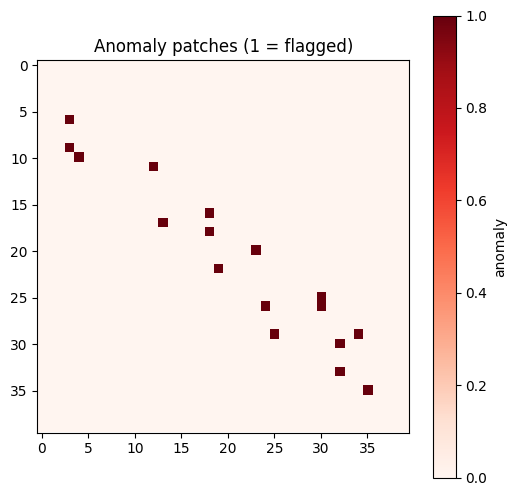

Wrote annotated image: analysis_out/annotated_anomalies.png


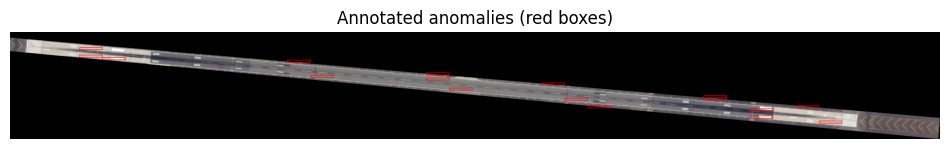

In [68]:
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Ensure df exists
if 'df' not in globals():
    raise RuntimeError("DataFrame `df` not found. Run the previous cell to create df from your maps.")

# choose features (adjust if you want to include others like HOG, LBP)
features = ["mean","std","skew","kurtosis","entropy"]
if not all(f in df.columns for f in features):
    raise RuntimeError("df missing required columns: " + ", ".join([c for c in features if c not in df.columns]))

# prepare X
X = df[features].fillna(0).values

# train IsolationForest
clf = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
y = clf.fit_predict(X)        # -1 anomaly, 1 normal
df["anomaly"] = (y == -1).astype(int)

print("Anomalies detected (patch count):", int(df["anomaly"].sum()))
display(df.sort_values(["anomaly","std"], ascending=[False, False]).head(20))

# Build anomaly_map
grid_h = int(df['iy'].max()) + 1
grid_w = int(df['ix'].max()) + 1
anomaly_map = np.zeros((grid_h, grid_w), dtype=int)
for _, row in df[df["anomaly"]==1].iterrows():
    anomaly_map[int(row['iy']), int(row['ix'])] = 1

# show anomaly_map
plt.figure(figsize=(6,6))
plt.imshow(anomaly_map, cmap='Reds', interpolation='nearest')
plt.title("Anomaly patches (1 = flagged)")
plt.colorbar(label="anomaly")
plt.show()

# Annotate original image with red rectangles around flagged patches
# compute patch pixel size (if not defined)
if 'ph' not in globals() or 'pw' not in globals():
    ph = h // grid
    pw = w // grid

img_pil = Image.fromarray(img_rgb.copy())
draw = ImageDraw.Draw(img_pil)
# optionally choose top-K anomalies if too many flagged
anomalies = df[df['anomaly']==1].copy()
K = 20
if len(anomalies) > K:
    anomalies = anomalies.sort_values('std', ascending=False).head(K)

for _, row in anomalies.iterrows():
    iy = int(row['iy']); ix = int(row['ix'])
    y0 = iy * ph; x0 = ix * pw
    y1 = min((iy+1)*ph, h); x1 = min((ix+1)*pw, w)
    draw.rectangle([x0, y0, x1, y1], outline=(255,0,0), width=3)

annotated_path = "analysis_out/annotated_anomalies.png"
img_pil.save(annotated_path)
print("Wrote annotated image:", annotated_path)

# display annotated image inline
plt.figure(figsize=(12,8))
plt.imshow(img_pil)
plt.axis('off')
plt.title("Annotated anomalies (red boxes)")
plt.show()

# Mistral

In [69]:
# 1 - CONFIGURATION & HELPERS
from pathlib import Path
import numpy as np
from PIL import Image
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import math, os


ROOT = Path(".").resolve()
CHIP = ROOT / "chips" / "misawa_airbase.Misawa_Airbase.Runway_1.tif"
OUT_DIR = ROOT / "analysis_out"
OUT_DIR.mkdir(exist_ok=True, parents=True)

# image intensity considered "background" threshold: sum of RGB <= BG_THRESH is background
BG_THRESH = 5   # tune if image uses near-black background/padding

print("Image:", CHIP)
print("Out dir:", OUT_DIR)


Image: C:\Users\bengb\OneDrive\Documents\SATSAR_Extract\chips\misawa_airbase.Misawa_Airbase.Runway_1.tif
Out dir: C:\Users\bengb\OneDrive\Documents\SATSAR_Extract\analysis_out


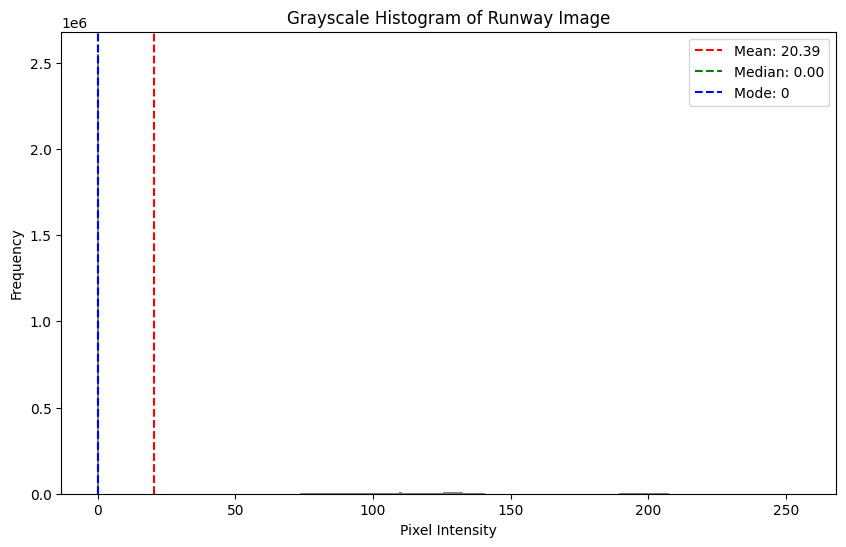

,Metric,Value
0,Mean,20.394800
1,Median,0.000000
2,Mode,0.000000
3,Variance,2447.195968
4,Skewness,2.375583
5,Kurtosis,4.771934


In [70]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import pandas as pd

# Load the image
img = Image.open(CHIP)
gray_img = img.convert('L')  # Convert to grayscale
gray_array = np.array(gray_img)

# Flatten the array for histogram and moments
flat_intensities = gray_array.flatten()

# Compute histogram
hist, bins = np.histogram(flat_intensities, bins=256, range=(0, 256))

# Calculate moments
mean_intensity = np.mean(flat_intensities)
median_intensity = np.median(flat_intensities)
mode_intensity = np.argmax(hist)  # Simplified mode (most frequent intensity)
var_intensity = np.var(flat_intensities)
skew_intensity = skew(flat_intensities)
kurtosis_intensity = kurtosis(flat_intensities)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], hist, width=1, color='gray')
plt.axvline(mean_intensity, color='r', linestyle='--', label=f'Mean: {mean_intensity:.2f}')
plt.axvline(median_intensity, color='g', linestyle='--', label=f'Median: {median_intensity:.2f}')
plt.axvline(mode_intensity, color='b', linestyle='--', label=f'Mode: {mode_intensity}')
plt.title('Grayscale Histogram of Runway Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Display moments as a DataFrame
moments_df = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Mode', 'Variance', 'Skewness', 'Kurtosis'],
    'Value': [mean_intensity, median_intensity, mode_intensity, var_intensity, skew_intensity, kurtosis_intensity]
})
moments_df


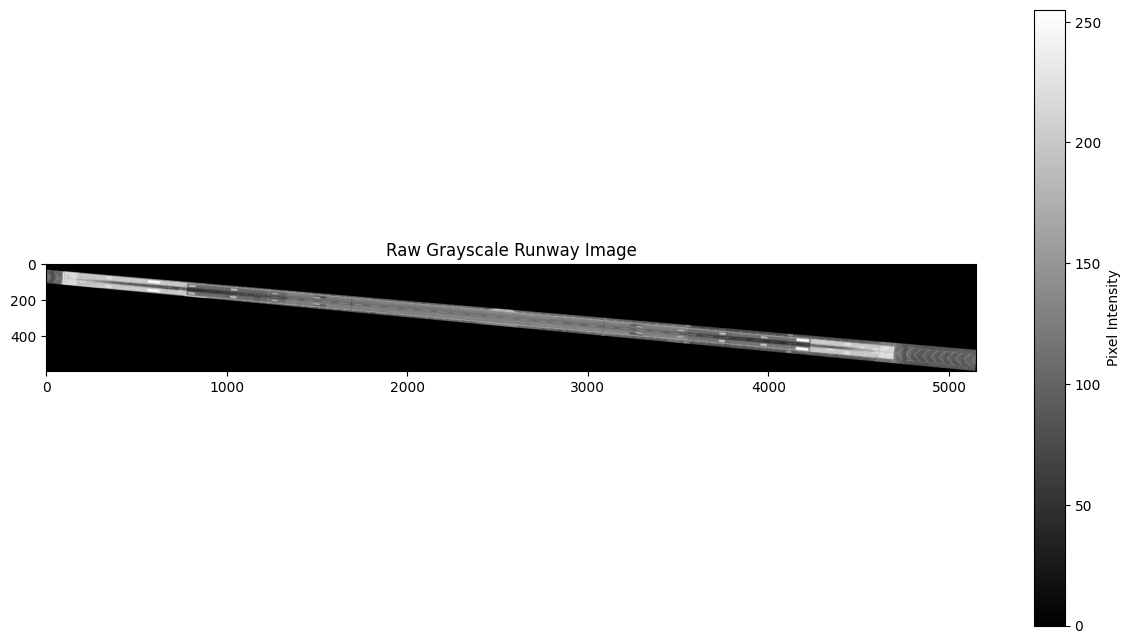

In [78]:
# Cell 3: EDA Extension - Visualize Image, Explore Thresholds, and Highlight Anomalies
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Visualize the Raw Grayscale Image ---
plt.figure(figsize=(15, 8))
plt.imshow(gray_array, cmap='gray', vmin=0, vmax=255)
plt.title("Raw Grayscale Runway Image")
plt.colorbar(label='Pixel Intensity')
plt.show()

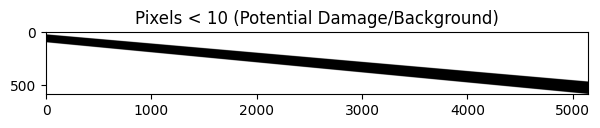

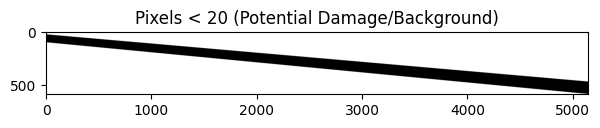

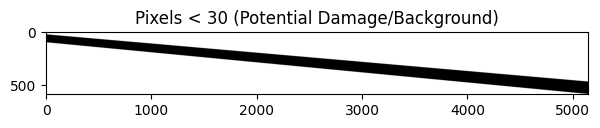

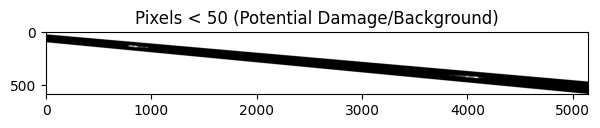

In [80]:
# --- 2. Explore Potential Thresholds for Damage or Background ---
# Let's try a few thresholds to see what they highlight
thresholds = [10, 20, 30, 50]  # Adjust based on your histogram

for thresh in thresholds:
    # Create a binary mask for pixels below the threshold
    potential_damage = gray_array < thresh
    # Visualize
    plt.figure(figsize=(7, 7))
    plt.imshow(potential_damage, cmap='gray')
    plt.title(f"Pixels < {thresh} (Potential Damage/Background)")
    plt.show()

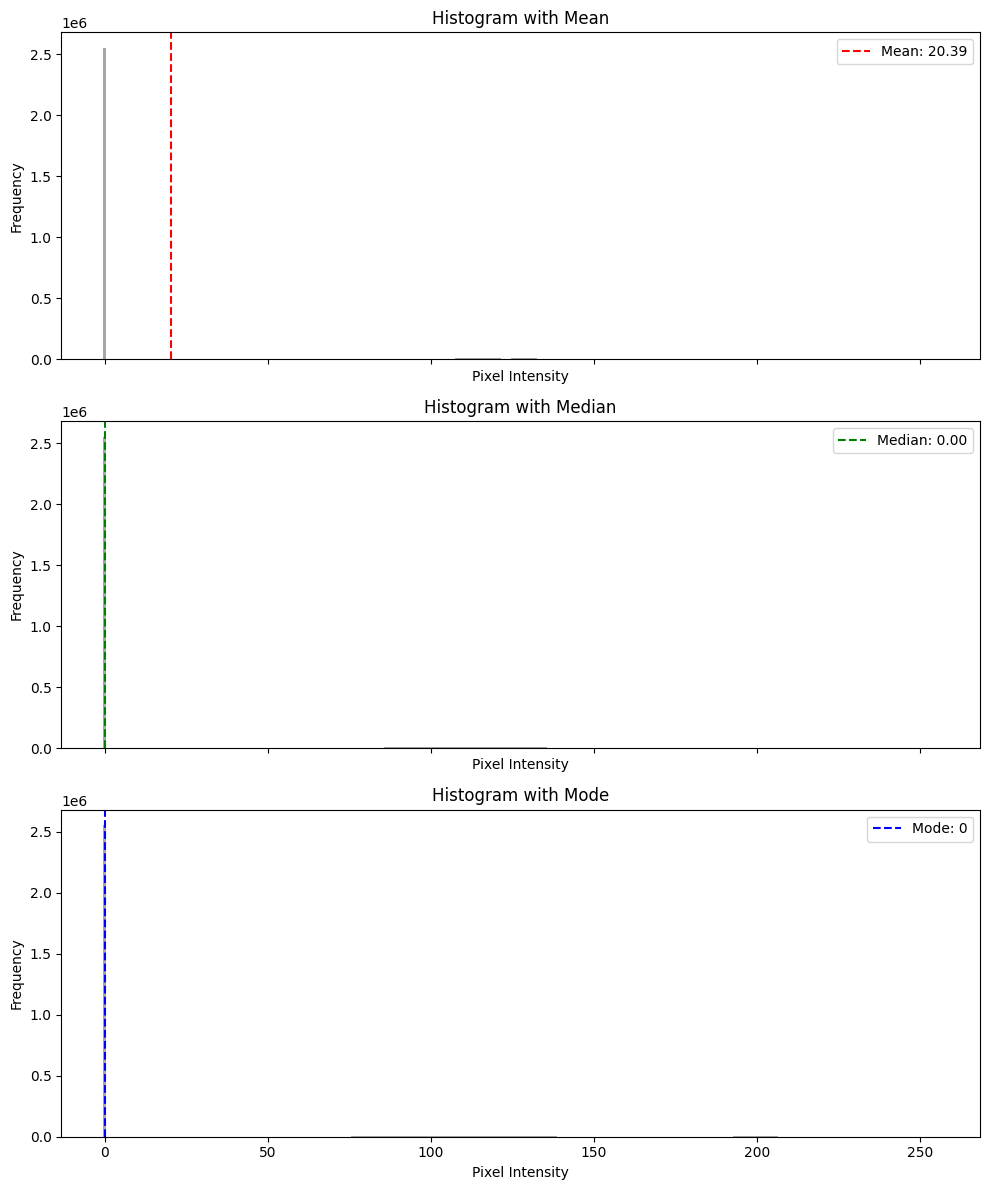

,Metric,Value
0,Mean,20.394800
1,Median,0.000000
2,Mode,0.000000
3,Variance,2447.195968
4,Skewness,2.375583
5,Kurtosis,4.771934


In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew, kurtosis

# Load the image
img = Image.open(CHIP)
gray_img = img.convert('L')  # Convert to grayscale
gray_array = np.array(gray_img)
flat_intensities = gray_array.flatten()

# Compute histogram
hist, bins = np.histogram(flat_intensities, bins=256, range=(0, 256))

# Calculate moments
mean_intensity = np.mean(flat_intensities)
median_intensity = np.median(flat_intensities)
mode_intensity = np.argmax(hist)  # Simplified mode (most frequent intensity)
var_intensity = np.var(flat_intensities)
skew_intensity = skew(flat_intensities)
kurtosis_intensity = kurtosis(flat_intensities)

# --- Create a faceted plot ---
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot 1: Histogram with Mean
axes[0].bar(bins[:-1], hist, width=1, color='gray', alpha=0.7)
axes[0].axvline(mean_intensity, color='red', linestyle='--', label=f'Mean: {mean_intensity:.2f}')
axes[0].set_title('Histogram with Mean')
axes[0].legend()

# Plot 2: Histogram with Median
axes[1].bar(bins[:-1], hist, width=1, color='gray', alpha=0.7)
axes[1].axvline(median_intensity, color='green', linestyle='--', label=f'Median: {median_intensity:.2f}')
axes[1].set_title('Histogram with Median')
axes[1].legend()

# Plot 3: Histogram with Mode
axes[2].bar(bins[:-1], hist, width=1, color='gray', alpha=0.7)
axes[2].axvline(mode_intensity, color='blue', linestyle='--', label=f'Mode: {mode_intensity}')
axes[2].set_title('Histogram with Mode')
axes[2].legend()

# Add x and y labels
for ax in axes:
    ax.set_xlabel('Pixel Intensity')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# --- Display moments as a DataFrame ---
moments_df = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Mode', 'Variance', 'Skewness', 'Kurtosis'],
    'Value': [mean_intensity, median_intensity, mode_intensity, var_intensity, skew_intensity, kurtosis_intensity]
})
moments_df


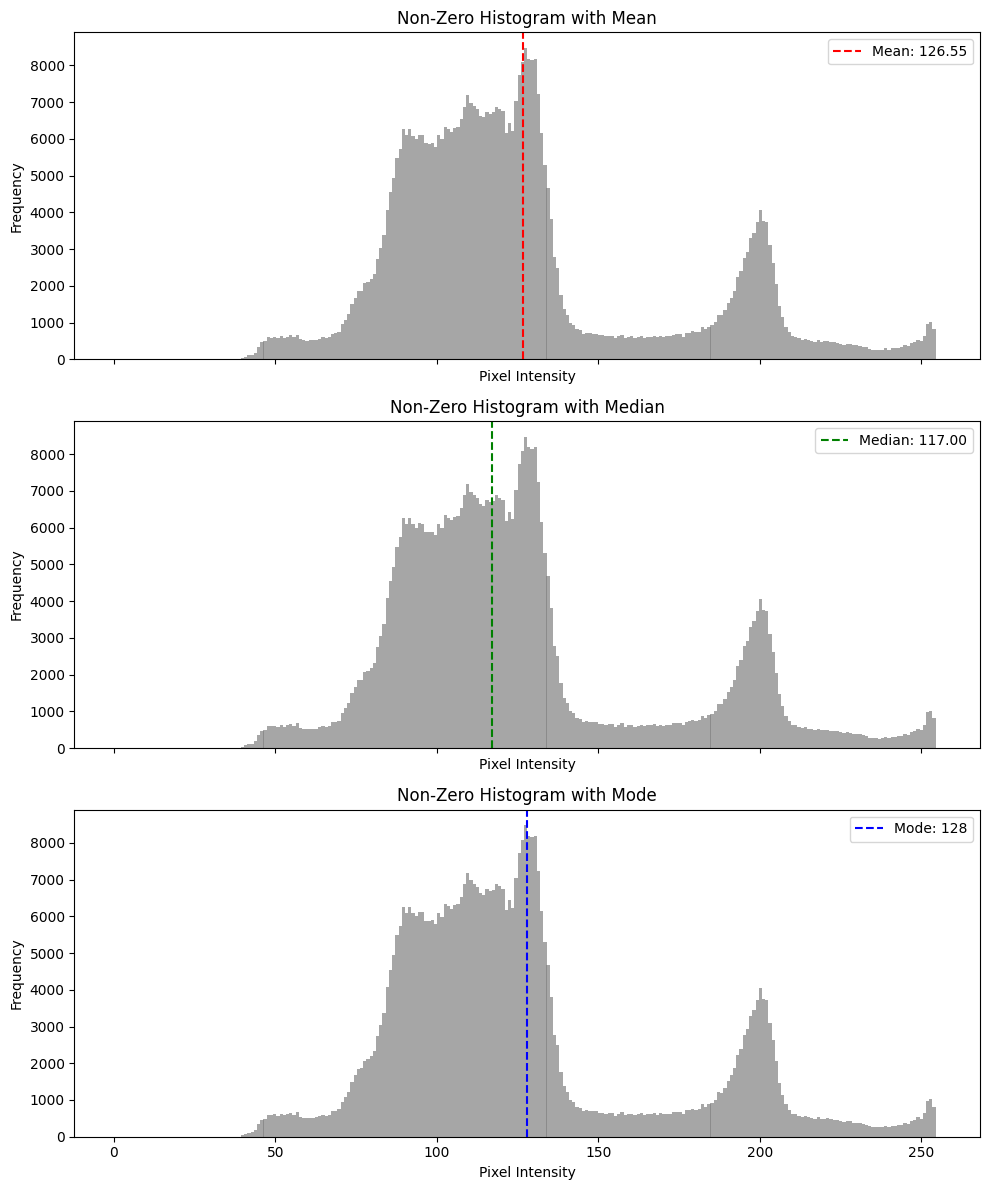

,Metric,Value
0,Mean,126.553788
1,Median,117.000000
2,Mode,128.000000


In [83]:
# Exclude 0-intensity pixels
non_zero_intensities = flat_intensities[flat_intensities > 0]

# Recompute histogram and moments
hist_nz, bins_nz = np.histogram(non_zero_intensities, bins=256, range=(1, 256))
mean_nz = np.mean(non_zero_intensities)
median_nz = np.median(non_zero_intensities)
mode_nz = np.argmax(np.bincount(non_zero_intensities.astype(int)))  # Mode of non-zero intensities

# --- Facet plot for non-zero intensities ---
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot 1: Histogram with Mean (Non-Zero)
axes[0].bar(bins_nz[:-1], hist_nz, width=1, color='gray', alpha=0.7)
axes[0].axvline(mean_nz, color='red', linestyle='--', label=f'Mean: {mean_nz:.2f}')
axes[0].set_title('Non-Zero Histogram with Mean')
axes[0].legend()

# Plot 2: Histogram with Median (Non-Zero)
axes[1].bar(bins_nz[:-1], hist_nz, width=1, color='gray', alpha=0.7)
axes[1].axvline(median_nz, color='green', linestyle='--', label=f'Median: {median_nz:.2f}')
axes[1].set_title('Non-Zero Histogram with Median')
axes[1].legend()

# Plot 3: Histogram with Mode (Non-Zero)
axes[2].bar(bins_nz[:-1], hist_nz, width=1, color='gray', alpha=0.7)
axes[2].axvline(mode_nz, color='blue', linestyle='--', label=f'Mode: {mode_nz}')
axes[2].set_title('Non-Zero Histogram with Mode')
axes[2].legend()

# Add x and y labels
for ax in axes:
    ax.set_xlabel('Pixel Intensity')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# --- Display updated moments ---
moments_nz_df = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Mode'],
    'Value': [mean_nz, median_nz, mode_nz]
})
moments_nz_df


# Pixel Intensity Thresholding Visualization

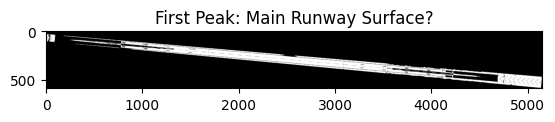

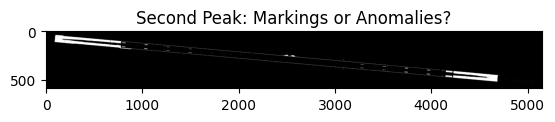

In [84]:
# Example: Mask for the first peak (e.g., 80 < intensity < 150)
peak1_mask = (gray_array > 80) & (gray_array < 150)
plt.imshow(peak1_mask, cmap='gray')
plt.title("First Peak: Main Runway Surface?")
plt.show()

# Example: Mask for the second peak (e.g., intensity > 180)
peak2_mask = (gray_array > 180)
plt.imshow(peak2_mask, cmap='gray')
plt.title("Second Peak: Markings or Anomalies?")
plt.show()


## Refine Your Mask for Damage Detection

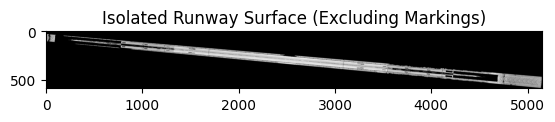

In [ ]:
# Apply the first peak mask to the grayscale image
runway_surface = gray_array.copy()
runway_surface[~peak1_mask] = 0  # Set non-runway pixels to 0

# Plot the isolated runway surface
plt.imshow(runway_surface, cmap='gray')
plt.title("Isolated Runway Surface (Excluding Markings)")
plt.show()

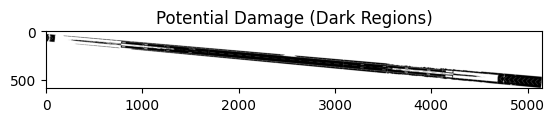

In [ ]:
import cv2
# Apply Otsu's thresholding to the runway surface
_, damage_mask = cv2.threshold(
    runway_surface,
    0,
    255,
    cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
)

# Plot the damage mask
plt.imshow(damage_mask, cmap='gray')
plt.title("Potential Damage (Dark Regions)")
plt.show()

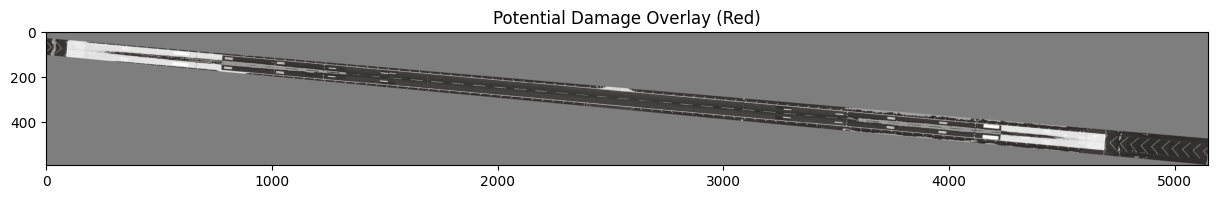

In [90]:
# Step 1: Isolate the runway surface
runway_surface = gray_array.copy()
runway_surface[~peak1_mask] = 0

# Step 2: Detect anomalies using Otsu's method
_, damage_mask = cv2.threshold(
    runway_surface,
    0,
    255,
    cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
)

# Step 3: Overlay damage mask on the original image
plt.figure(figsize=(15, 15))
plt.imshow(gray_array, cmap='gray')
plt.imshow(damage_mask, cmap='hot', alpha=0.5)  # Overlay in red
plt.title("Potential Damage Overlay (Red)")
plt.show()


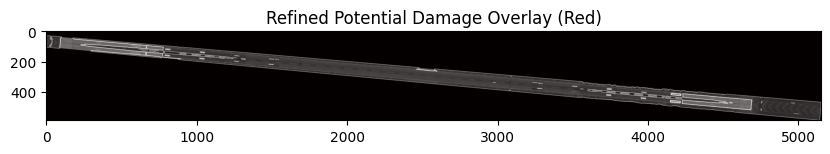

In [93]:
# Step 1: Adaptive thresholding
damage_mask = cv2.adaptiveThreshold(
    runway_surface,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    11,
    2
)

# Step 2: Morphological opening
kernel = np.ones((3, 3), np.uint8)
damage_mask = cv2.morphologyEx(damage_mask, cv2.MORPH_OPEN, kernel)

# Step 3: Filter small components
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(damage_mask)
for label in range(1, num_labels):
    if stats[label, cv2.CC_STAT_AREA] < 100:  # Adjust threshold as needed
        damage_mask[labels == label] = 0

# Step 4: Overlay refined damage mask
plt.figure(figsize=(10, 6))
plt.imshow(gray_array, cmap='gray')
plt.imshow(damage_mask, cmap='hot', alpha=0.5)
plt.title("Refined Potential Damage Overlay (Red)")
plt.show()


In [96]:
import cv2
import numpy as np
from pathlib import Path

# Define the full path to the image
ROOT = Path(".")
CHIP = ROOT / "chips" / "misawa_airbase.Misawa_Airbase.Runway_1.tif"

# Load the image
runway_img = cv2.imread(str(CHIP), cv2.IMREAD_GRAYSCALE)
if runway_img is None:
    raise FileNotFoundError(f"Could not load the image at {CHIP}. Check the file path or format.")

# Add synthetic potholes
for _ in range(5):
    x, y = np.random.randint(500, 4500, 2)
    radius = np.random.randint(10, 50)
    cv2.circle(runway_img, (x, y), radius, 50, -1)

# Add synthetic cracks
for _ in range(3):
    pts = np.random.randint(500, 4500, (5, 2))
    cv2.polylines(runway_img, [pts], False, 30, 2)

# Save the modified image
cv2.imwrite(str(ROOT / "chips" / "runway_with_damage.tif"), runway_img)
print("Image saved successfully!")



Image saved successfully!


In [97]:
# Add synthetic potholes (dark irregular circles)
for _ in range(5):  # Add 5 random potholes
    x, y = np.random.randint(500, 4500, 2)  # Random location
    radius = np.random.randint(10, 50)     # Random size
    cv2.circle(runway_img, (x, y), radius, 50, -1)  # Draw filled circle (intensity=50)

# Add synthetic cracks (dark jagged lines)
for _ in range(3):
    pts = np.random.randint(500, 4500, (5, 2))  # Random points
    cv2.polylines(runway_img, [pts], False, 30, 2)  # Draw jagged line (intensity=30)

# Save the modified image
cv2.imwrite('runway_with_damage.tif', runway_img)

# Now apply your detection pipeline to 'runway_with_damage.tif'

True

In [3]:
import os
# get current working directory
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: c:\Users\bengb\OneDrive\Documents\SATSAR_Extract


# Damaged Runway

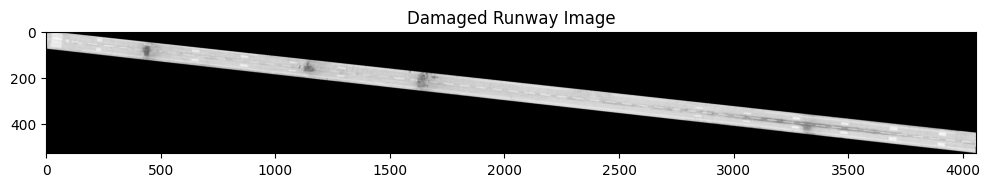

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Define the path to the damaged runway image
damaged_path = Path(r"analysis_out\DamageRunway2.png")

# Load the image in grayscale
damaged_img = cv2.imread(str(damaged_path), cv2.IMREAD_GRAYSCALE)
if damaged_img is None:
    raise FileNotFoundError(f"Could not load the image at {damaged_path}. Check the file path or format.")

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(damaged_img, cmap='gray')
plt.title("Damaged Runway Image")
plt.show()


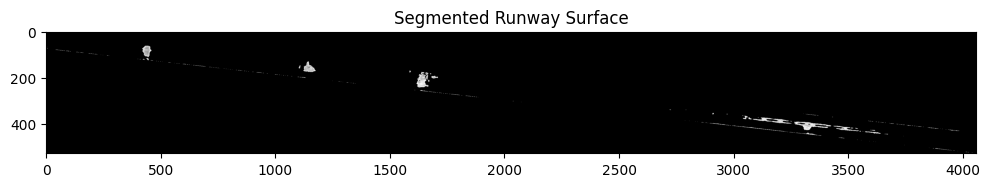

In [22]:
# Segment the runway surface (adjust thresholds as needed)
peak1_mask = (damaged_img > 80) & (damaged_img < 150)  # Example thresholds
runway_surface = damaged_img.copy()
runway_surface[~peak1_mask] = 0  # Set non-runway pixels to 0

# Display the segmented runway surface
plt.figure(figsize=(12, 8))
plt.imshow(runway_surface, cmap='gray')
plt.title("Segmented Runway Surface")
plt.show()


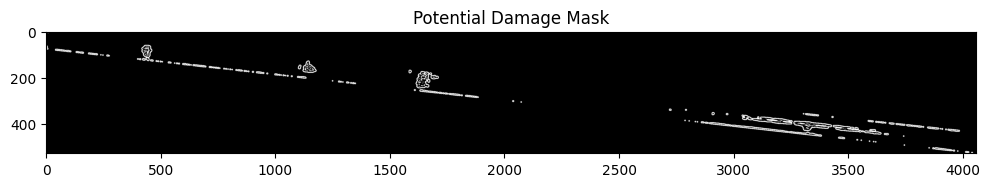

In [23]:
# Adaptive thresholding to detect anomalies
damage_mask = cv2.adaptiveThreshold(
    runway_surface,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    11,  # Neighborhood size
    2    # Sensitivity
)

# Display the damage mask
plt.figure(figsize=(12, 8))
plt.imshow(damage_mask, cmap='gray')
plt.title("Potential Damage Mask")
plt.show()


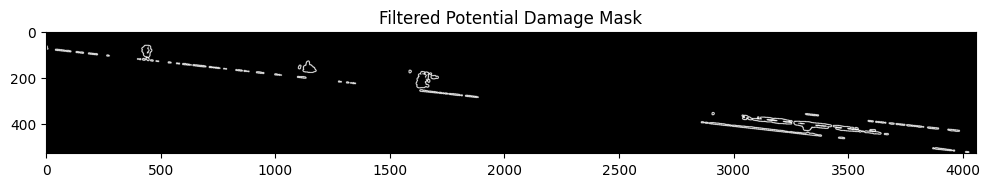

In [24]:
# Morphological opening to reduce noise
kernel = np.ones((3, 3), np.uint8)
damage_mask = cv2.morphologyEx(damage_mask, cv2.MORPH_OPEN, kernel)

# Filter small components
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(damage_mask)
for label in range(1, num_labels):
    if stats[label, cv2.CC_STAT_AREA] < 100:  # Adjust area threshold
        damage_mask[labels == label] = 0

# Display the filtered damage mask
plt.figure(figsize=(12, 8))
plt.imshow(damage_mask, cmap='gray')
plt.title("Filtered Potential Damage Mask")
plt.show()


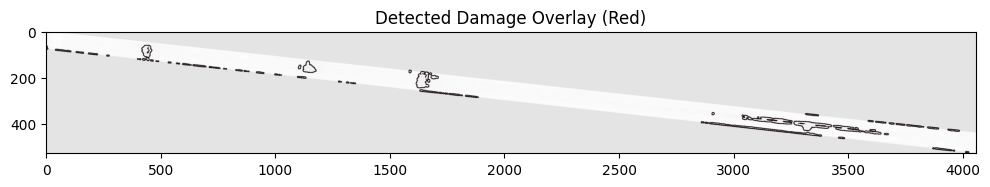

In [34]:
# Overlay the damage mask on the original image
plt.figure(figsize=(12, 8))
plt.imshow(damaged_img, cmap='gray')
plt.imshow(damage_mask, cmap='hot', alpha=.9)  # Overlay in red
plt.title("Detected Damage Overlay (Red)")
plt.show()


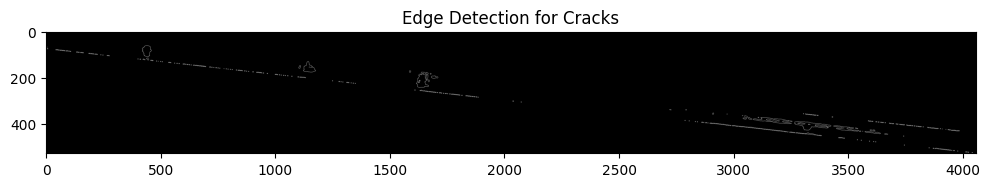

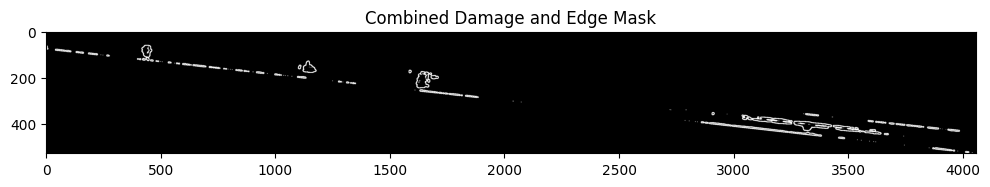

In [26]:
# Apply Canny edge detection
edges = cv2.Canny(runway_surface, threshold1=50, threshold2=150)

# Display edges
plt.figure(figsize=(12, 8))
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection for Cracks")
plt.show()

# Combine edges with the damage mask
combined_mask = cv2.bitwise_or(damage_mask, edges)
plt.figure(figsize=(12, 8))
plt.imshow(combined_mask, cmap='gray')
plt.title("Combined Damage and Edge Mask")
plt.show()


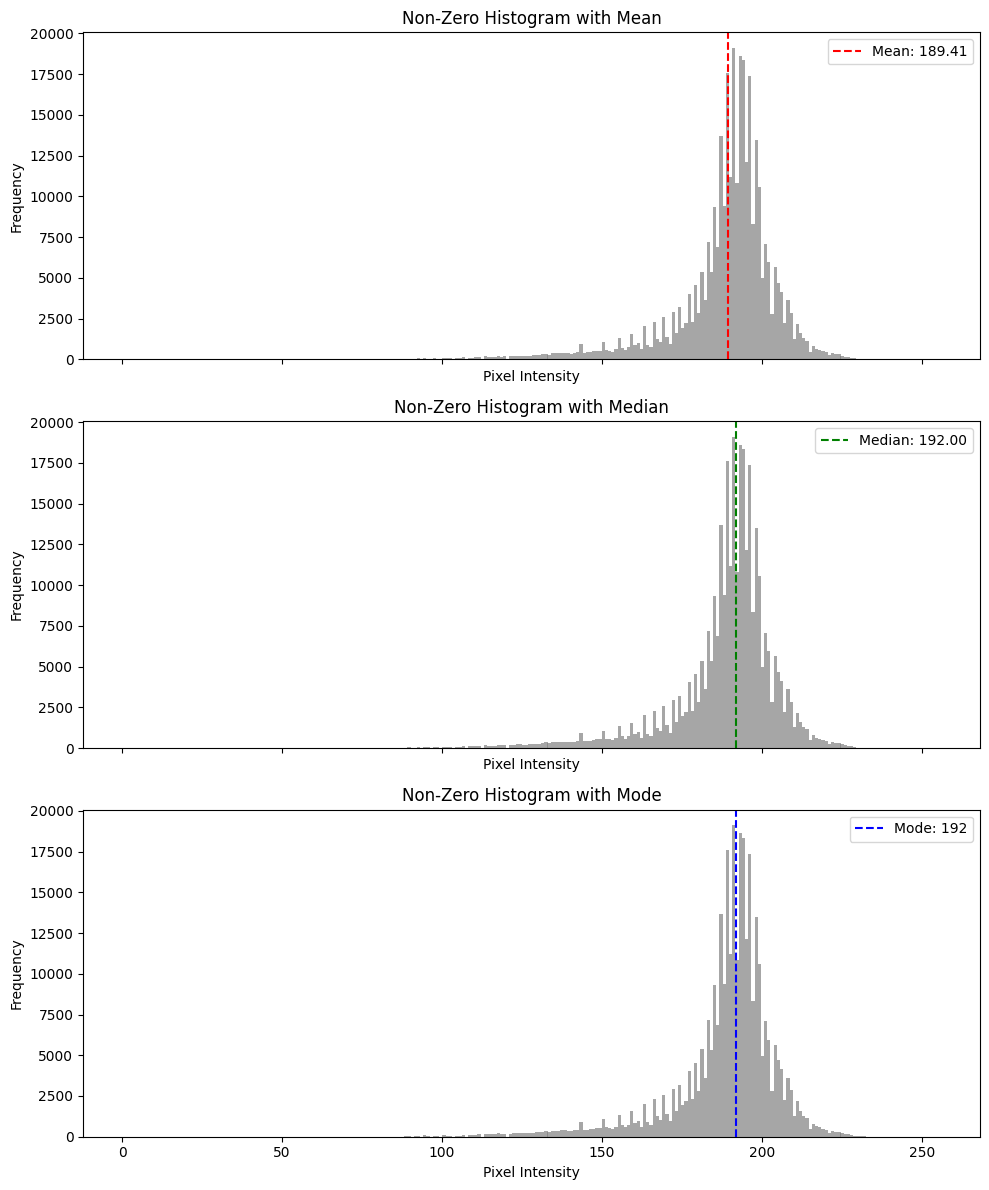

   Metric       Value
0    Mean  189.408578
1  Median  192.000000
2    Mode  192.000000


In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Load the damaged runway image
damaged_path = Path(r"analysis_out\DamageRunway2.png")
damaged_img = cv2.imread(str(damaged_path), cv2.IMREAD_GRAYSCALE)

if damaged_img is None:
    raise FileNotFoundError(f"Could not load the image at {damaged_path}. Check the file path or format.")

# Flatten the image array
flat_intensities = damaged_img.flatten()

# Exclude 0-intensity pixels
non_zero_intensities = flat_intensities[flat_intensities > 0]

# Recompute histogram and moments
hist_nz, bins_nz = np.histogram(non_zero_intensities, bins=256, range=(1, 256))
mean_nz = np.mean(non_zero_intensities)
median_nz = np.median(non_zero_intensities)
mode_nz = np.argmax(np.bincount(non_zero_intensities.astype(int)))  # Mode of non-zero intensities

# --- Facet plot for non-zero intensities ---
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot 1: Histogram with Mean (Non-Zero)
axes[0].bar(bins_nz[:-1], hist_nz, width=1, color='gray', alpha=0.7)
axes[0].axvline(mean_nz, color='red', linestyle='--', label=f'Mean: {mean_nz:.2f}')
axes[0].set_title('Non-Zero Histogram with Mean')
axes[0].legend()

# Plot 2: Histogram with Median (Non-Zero)
axes[1].bar(bins_nz[:-1], hist_nz, width=1, color='gray', alpha=0.7)
axes[1].axvline(median_nz, color='green', linestyle='--', label=f'Median: {median_nz:.2f}')
axes[1].set_title('Non-Zero Histogram with Median')
axes[1].legend()

# Plot 3: Histogram with Mode (Non-Zero)
axes[2].bar(bins_nz[:-1], hist_nz, width=1, color='gray', alpha=0.7)
axes[2].axvline(mode_nz, color='blue', linestyle='--', label=f'Mode: {mode_nz}')
axes[2].set_title('Non-Zero Histogram with Mode')
axes[2].legend()

# Add x and y labels
for ax in axes:
    ax.set_xlabel('Pixel Intensity')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# --- Display updated moments ---
moments_nz_df = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Mode'],
    'Value': [mean_nz, median_nz, mode_nz]
})

print(moments_nz_df)


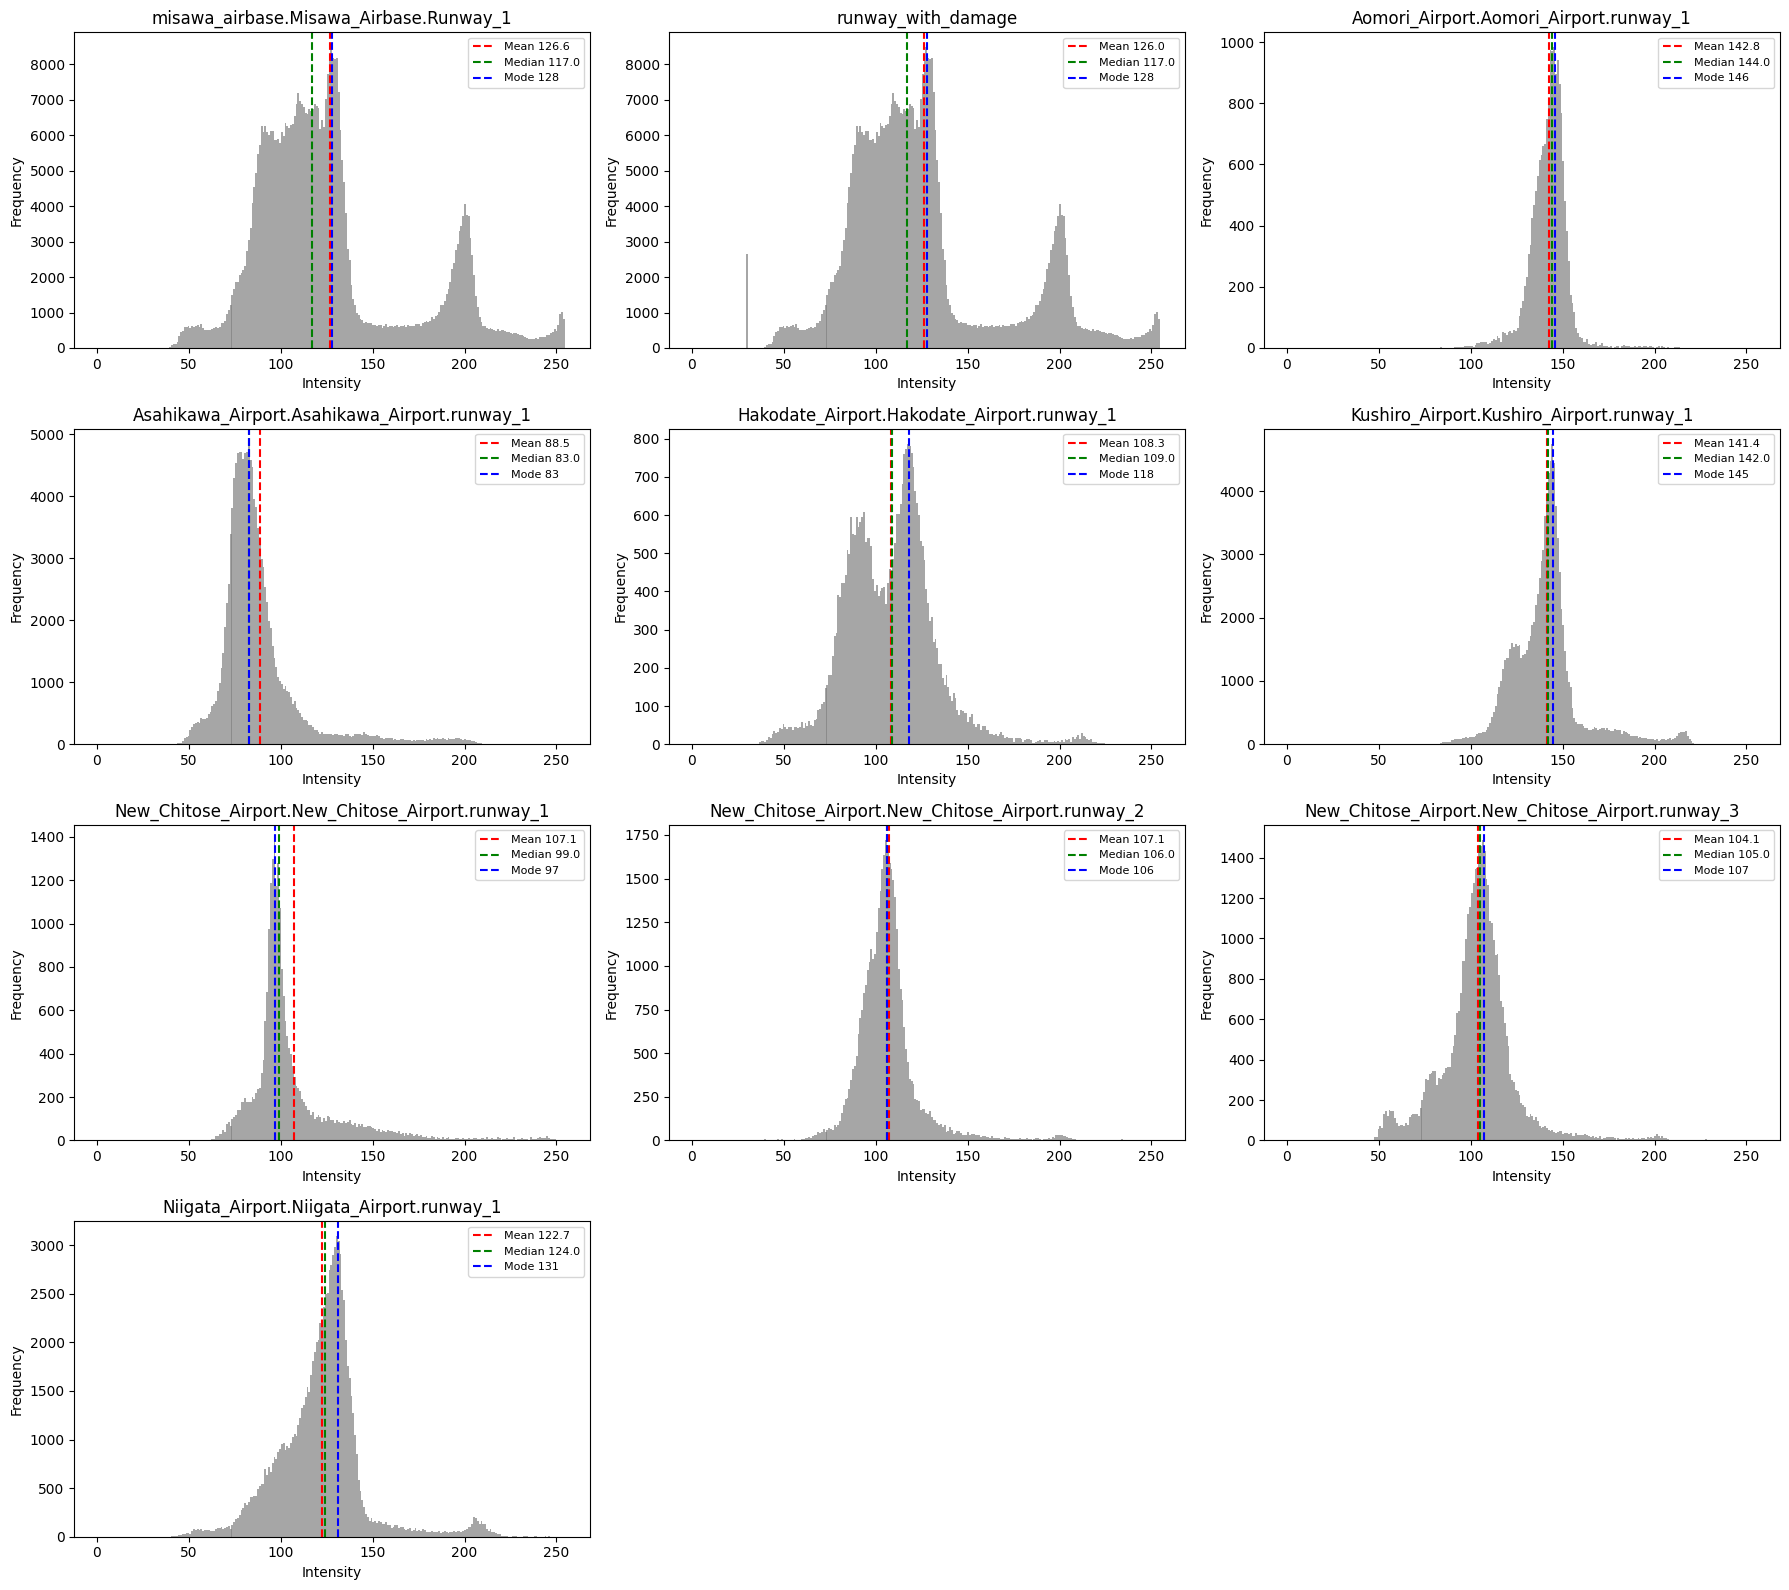

                                              Image        Mean  Median  Mode
0            misawa_airbase.Misawa_Airbase.Runway_1  126.554077   117.0   128
1                                runway_with_damage  126.034259   117.0   128
2            Aomori_Airport.Aomori_Airport.runway_1  142.812080   144.0   146
3      Asahikawa_Airport.Asahikawa_Airport.runway_1   88.524006    83.0    83
4        Hakodate_Airport.Hakodate_Airport.runway_1  108.315143   109.0   118
5          Kushiro_Airport.Kushiro_Airport.runway_1  141.381419   142.0   145
6  New_Chitose_Airport.New_Chitose_Airport.runway_1  107.129384    99.0    97
7  New_Chitose_Airport.New_Chitose_Airport.runway_2  107.104814   106.0   106
8  New_Chitose_Airport.New_Chitose_Airport.runway_3  104.104340   105.0   107
9          Niigata_Airport.Niigata_Airport.runway_1  122.701870   124.0   131


In [38]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import math

# Define the root folder
root_folder = Path(r"C:\Users\bengb\OneDrive\Documents\SATSAR_Extract\chips")

# Analyze one image (no plotting)
def analyze_image(image_path):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Could not load image: {image_path}")
        return None

    flat = img.flatten()
    nz = flat[flat > 0]

    if nz.size == 0:
        print(f"No non-zero pixels in image: {image_path}")
        return None

    # Statistics
    mean = np.mean(nz)
    median = np.median(nz)
    mode = np.argmax(np.bincount(nz.astype(int)))

    # Histogram
    hist, bins = np.histogram(nz, bins=256, range=(1, 256))

    return {
        "name": image_path.stem,
        "hist": hist,
        "bins": bins,
        "mean": mean,
        "median": median,
        "mode": mode
    }

# Traverse and analyze
def analyze_all_images(root_folder):
    results = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.lower().endswith((".tif", ".tiff")):
                image_path = Path(root) / file
                result = analyze_image(image_path)
                if result:
                    results.append(result)
    return results

# Create one facet plot for all images
def plot_facet_histograms(results):
    n = len(results)
    cols = 3  # you can change this
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
    axes = axes.flatten()  # make indexing easier

    for i, res in enumerate(results):
        ax = axes[i]

        hist = res["hist"]
        bins = res["bins"]
        mean = res["mean"]
        median = res["median"]
        mode = res["mode"]

        ax.bar(bins[:-1], hist, width=1, color="gray", alpha=0.7)
        ax.axvline(mean, color="red", linestyle="--", label=f"Mean {mean:.1f}")
        ax.axvline(median, color="green", linestyle="--", label=f"Median {median:.1f}")
        ax.axvline(mode, color="blue", linestyle="--", label=f"Mode {mode}")

        ax.set_title(res["name"])
        ax.set_xlabel("Intensity")
        ax.set_ylabel("Frequency")
        ax.legend(fontsize=8)

    # Turn off unused panels if fewer images than subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


# Run
results = analyze_all_images(root_folder)
plot_facet_histograms(results)

# Optional DataFrame of stats
df = pd.DataFrame([
    {"Image": r["name"], "Mean": r["mean"], "Median": r["median"], "Mode": r["mode"]}
    for r in results
])
print(df)
